In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import xeofs as xe
from pygments.modeline import modeline_re

from geometry_izzyv1 import grad_sphere
from regression_izzyv1 import linregress_3D
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
import warnings
import os
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'geometry_izzyv1'

In [38]:
# constant
rho_a = 1.225 # air density kg m-3
Cd = 1.5e-3 # drag coeff

In [39]:
gridtype = 'remapcon'

In [40]:
import netCDF4
import h5netcdf

In [41]:
# dot dataset
path = '/Users/iw2g24/PycharmProjects/SSH_project/'
print(path)
ds = xr.open_dataset(path + 'Data/dot_all_30bmedian_goco05c_sig3_1.nc')
print(ds)
# ERA5 remap dataset
ds_era5 = xr.open_dataset(path + 'Data/ERA5_u10v10_Antartica_2000-2023_' + gridtype + '.nc')

/Users/iw2g24/PycharmProjects/SSH_project/
<xarray.Dataset> Size: 109MB
Dimensions:          (longitude: 360, latitude: 64, time: 196, edge_lat: 65,
                      edge_lon: 361)
Coordinates:
  * longitude        (longitude) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * latitude         (latitude) float64 512B -81.75 -81.25 ... -50.75 -50.25
  * time             (time) datetime64[ns] 2kB 2002-07-01 ... 2018-10-01
  * edge_lat         (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -50.5 -50.0
  * edge_lon         (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 179.0 180.0
Data variables:
    dot              (longitude, latitude, time) float64 36MB ...
    ug               (longitude, latitude, time) float64 36MB ...
    vg               (longitude, latitude, time) float64 36MB ...
    land_mask        (longitude, latitude) float64 184kB ...
    intersat_offset  float64 8B ...
Attributes:
    history:      Created 08/01/2022, 00:5223
    description:  ENVISAT + CryoSat2 altimetry 

In [42]:
# change coordinates from (lon,lat,time) to (time,lat,lon) as ERA5
lon = ds['longitude'].values; lat = ds['latitude'].values
dot_all = ds['dot'].values
dot = np.zeros((dot_all.shape[2], dot_all.shape[1], dot_all.shape[0]))
for t in range(0,dot_all.shape[2]):
    for i in range(0,dot_all.shape[1]):
        for j in range(0,dot_all.shape[0]):
            dot[t,i,j] = dot_all[j,i,t].copy()
seamask = dot[0].copy()/dot[0]
seamask[seamask == 0] = np.nan
del dot_all

In [43]:
# make lon lat 2d
llon = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[1]):
    llon[i,:] = lon
llat = np.zeros((dot.shape[1],dot.shape[2]))
for i in range(0,dot.shape[2]):
    llat[:,i] = lat

In [44]:
dot.shape

(196, 64, 360)

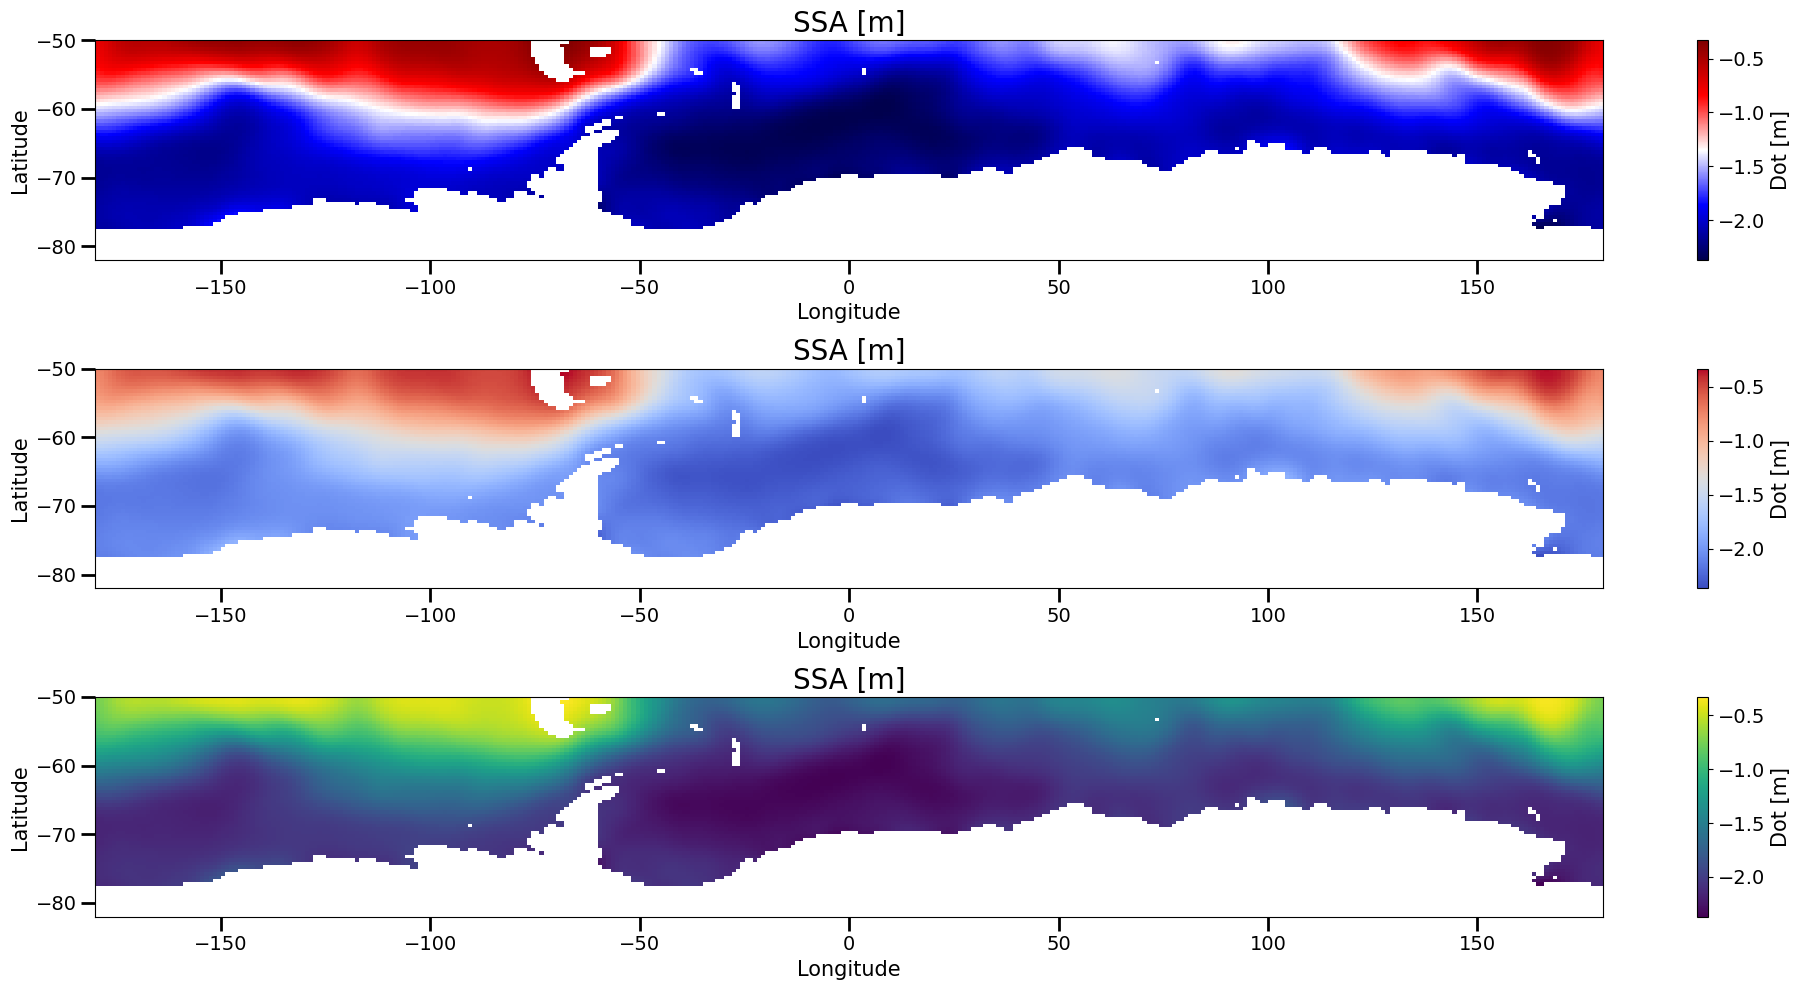

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))

pc1 = axes[0].pcolormesh(llon,llat,dot[0], cmap='seismic')
axes[0].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[0].set_title('SSA [m]', fontsize=20)
axes[0].set_xlabel('Longitude', fontsize=15)
axes[0].set_ylabel('Latitude', fontsize=15)
cbar1 = fig.colorbar(pc1, ax=axes[0])
cbar1.set_label('Dot [m]', fontsize=15)
cbar1.ax.tick_params(labelsize=14)

pc2 = axes[1].pcolormesh(llon,llat,dot[0], cmap='coolwarm')
axes[1].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[1].set_title('SSA [m]', fontsize=20)
axes[1].set_xlabel('Longitude', fontsize=15)
axes[1].set_ylabel('Latitude', fontsize=15)
cbar2 = fig.colorbar(pc2, ax=axes[1])
cbar2.set_label('Dot [m]', fontsize=15)
cbar2.ax.tick_params(labelsize=14)

pc3 = axes[2].pcolormesh(llon,llat,dot[0], cmap='viridis')
axes[2].tick_params(axis='both', which='major', length=10, width=2, labelsize=14)
axes[2].set_title('SSA [m]', fontsize=20)
axes[2].set_xlabel('Longitude', fontsize=15)
axes[2].set_ylabel('Latitude', fontsize=15)
cbar3 = fig.colorbar(pc3, ax=axes[2])
cbar3.set_label('Dot [m]', fontsize=15)
cbar3.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [46]:
# time
time_era5 = ds_era5['time'].values
time_dot = ds['time'].values

In [47]:
print(time_dot[0],time_dot[-1])
print(time_era5[30],time_era5[225])

2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000
2002-07-01T00:00:00.000000000 2018-10-01T00:00:00.000000000


In [48]:
tstart_era5 = 30
tend_era5 = 226 # +1 respect cell above

In [49]:
# select wind
u10 = ds_era5['u10'][tstart_era5:tend_era5].values
v10 = ds_era5['v10'][tstart_era5:tend_era5].values

# map lat in lat[::-1] when using gridboxmean mapping
# since lat in ERA5 goes from -50 to -80 instead in dot goes from -80 to -50
if gridtype == 'gridboxmean':
    print('you are using ',gridtype)
    u10 = u10[:,::-1,:]  
    v10 = v10[:,::-1,:]  
    
u10 = u10*seamask
v10 = v10*seamask
U = np.sqrt(u10**2. + v10**2.)

In [50]:
# wind stress
tau_x = rho_a*Cd*U*u10 #zonal wind
tau_y = rho_a*Cd*U*v10 #meridional wind

print('zonal wind:', tau_x)
print('meridional wind:', tau_y)

zonal wind: [[[       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  ...
  [0.02068101 0.01995691 0.01893414 ... 0.02478185 0.02406133 0.02285532]
  [0.02073882 0.02002566 0.01897176 ... 0.02542477 0.02491941 0.02391698]
  [0.02081135 0.01977531 0.01851727 ... 0.02508504 0.02510456 0.0242639 ]]

 [[       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  [       nan        nan        nan ...        nan        nan        nan]
  ...
  [0.02263992 0.02283532 0.02308318 ... 0.0202767  0.02100487 0.02146125]
  [0.01919219 0.01941123 0.01973684 ... 0.01726765 0.01758919 0.01786926]
  [0.01712514 0.01781618 0.01820304 ... 0.01602753 0.01570514 0.01575291]]

 [[       nan        nan        nan ...        nan        nan        nan]
  [       

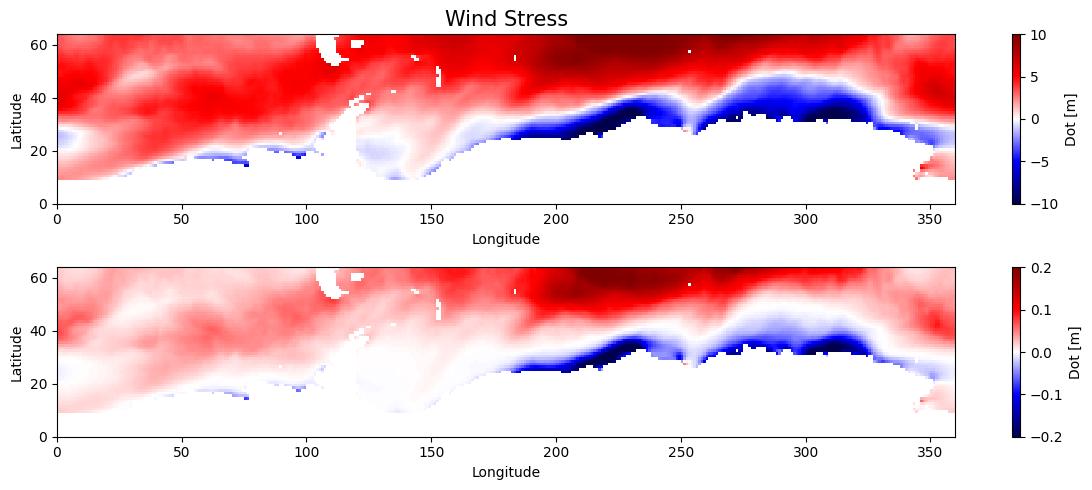

In [51]:
fig = plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.pcolormesh(u10[0],cmap='seismic',vmin=-10,vmax=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wind Stress', fontsize=15)
cbar1= plt.colorbar()
cbar1.set_label('Dot [m]')
plt.subplot(2,1,2)
plt.pcolormesh(tau_x[0],cmap='seismic',vmin=-0.2,vmax=0.2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cbar2= plt.colorbar()
cbar2.set_label('Dot [m]')


plt.tight_layout()


In [52]:
# wind stress curl
ws_curl = np.zeros(tau_x.shape)
for t in range(0,dot.shape[0]):
    dtaux_dx, dtaux_dy = grad_sphere(tau_x[t], llon, llat)
    dtauy_dx, dtauy_dy = grad_sphere(tau_y[t], llon, llat)
    ws_curl[t] = dtauy_dx - dtaux_dy

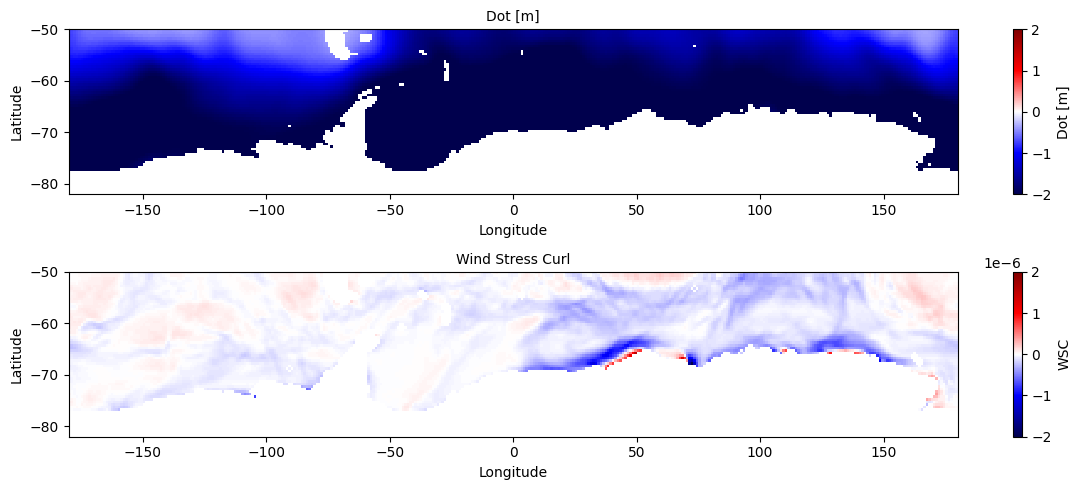

In [53]:
fig = plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.pcolormesh(llon, llat, dot[0], vmin=-2, vmax=2, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Dot [m]', fontsize=10)
ws1bar = plt.colorbar()
ws1bar.set_label('Dot [m]')

plt.subplot(2,1,2)
plt.pcolormesh(llon, llat, ws_curl[0], vmin=-2e-6, vmax=2e-6, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wind Stress Curl', fontsize=10)
#plt.quiver(llon, llat, u10[0], v10[0])
ws2bar = plt.colorbar()
ws2bar.set_label('WSC')

plt.tight_layout()

In [19]:
# DE-TREND

In [54]:
# linear regression in time on each grid point
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot)
# remove trend for dot
xt = np.zeros(dot.shape)
for t in range(0,dot.shape[0]):
    xt[t] = t
dot_detrended = dot - (slope*xt + intercept)

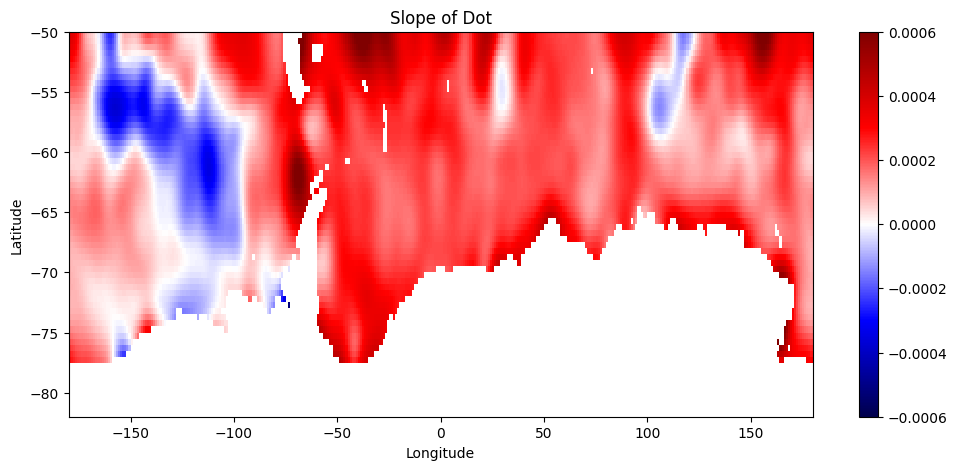

In [55]:
plt.figure(figsize=(12,5))
plt.pcolormesh(lon, lat, slope, vmin=-6e-4, vmax=6e-4, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slope of Dot')
plt.colorbar()


In [56]:
# linear regression in time on each grid point
n,slope,intercept,p_val,r_square,rmse = linregress_3D(ws_curl)
# remove trend for ws_curl
xt = np.zeros(ws_curl.shape)
for t in range(0,ws_curl.shape[0]):
    xt[t] = t
ws_curl_detrended = ws_curl - (slope*xt + intercept)

In [57]:
#dot_final = dot_detrended.copy()
#ws_curl_final = ws_curl_detrended.copy()

In [58]:
# DE-SEASONAL

In [59]:
months = time_dot.astype('datetime64[M]').astype(int) % 12 + 1
print(months)

[ 7  8  9 10 11 12  1  2  3  4  5  6  7  8  9 10 11 12  1  2  3  4  5  6
  7  8  9 10 11 12  1  2  3  4  5  6  7  8  9 10 11 12  1  2  3  4  5  6
  7  8  9 10 11 12  1  2  3  4  5  6  7  8  9 10 11 12  1  2  3  4  5  6
  7  8  9 10 11 12  1  2  3  4  5  6  7  8  9 10 11 12  1  2  3  4  5  6
  7  8  9 10 11 12  1  2  3  4  5  6  7  8  9 10 11 12  1  2  3  4  5  6
  7  8  9 10 11 12  1  2  3  4  5  6  7  8  9 10 11 12  1  2  3  4  5  6
  7  8  9 10 11 12  1  2  3  4  5  6  7  8  9 10 11 12  1  2  3  4  5  6
  7  8  9 10 11 12  1  2  3  4  5  6  7  8  9 10 11 12  1  2  3  4  5  6
  7  8  9 10]


In [60]:
# find and remove seasonality from dot_detrended and ws_curl_detrended
dot_seas = np.zeros((12,dot.shape[1],dot.shape[2])); ws_curl_seas = np.zeros((12,dot.shape[1],dot.shape[2]))
for m in range(1,13):
    dot_seas[m-1] = np.nanmean(dot_detrended[np.where(months==m)], axis=0)
    ws_curl_seas[m-1] = np.nanmean(ws_curl_detrended[np.where(months==m)], axis=0)

# remove seasonality
dot_final = np.zeros(dot_detrended.shape); ws_curl_final = np.zeros(ws_curl_detrended.shape)
for i,m in enumerate(months):
    dot_final[i] = dot_detrended[i] - dot_seas[m-1]
    ws_curl_final[i] = ws_curl_detrended[i] - ws_curl_seas[m-1]

In [61]:
print(dot.shape)
print(dot[0])
# print(dot[1])
# print(dot[2])

(196, 64, 360)
[[        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.75397619 -0.73751731 -0.71145781 ... -0.71390379 -0.74343705
  -0.75675648]
 [-0.74548579 -0.72969073 -0.70308686 ... -0.69892569 -0.73085478
  -0.74653662]
 [-0.74081023 -0.72535831 -0.69847726 ... -0.69097384 -0.7240913
  -0.74097281]]


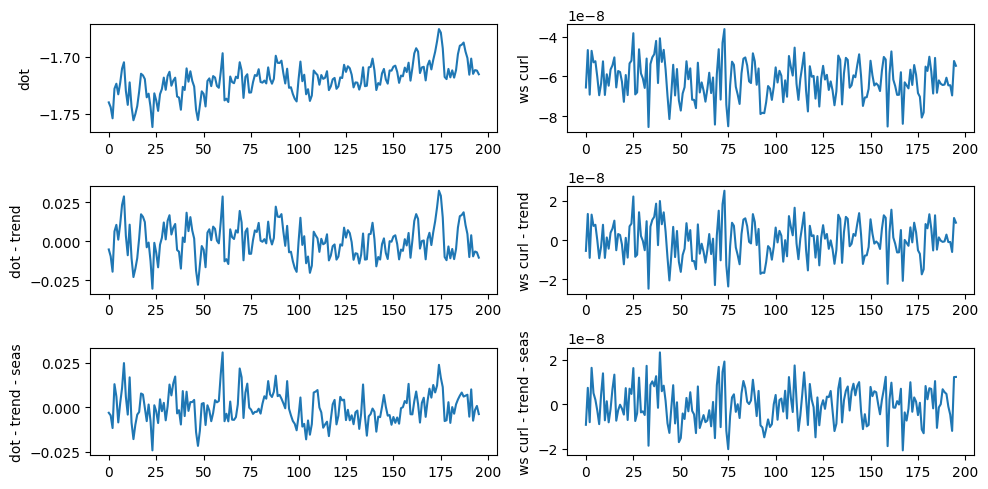

In [62]:
fig = plt.figure(figsize=(10,5))
plt.subplot(3,2,1)
plt.plot(np.nanmean(dot, axis=(1,2)))
plt.ylabel('dot')
plt.subplot(3,2,2)
plt.plot(np.nanmean(ws_curl, axis=(1,2)))
plt.ylabel('ws curl')
plt.subplot(3,2,3)
plt.plot(np.nanmean(dot_detrended, axis=(1,2)))
plt.ylabel('dot - trend')
plt.subplot(3,2,4)
plt.plot(np.nanmean(ws_curl_detrended, axis=(1,2)))
plt.ylabel('ws curl - trend')
plt.subplot(3,2,5)
plt.plot(np.nanmean(dot_final, axis=(1,2)))
plt.ylabel('dot - trend - seas')
plt.subplot(3,2,6)
plt.plot(np.nanmean(ws_curl_final, axis=(1,2)))
plt.ylabel('ws curl - trend - seas')

plt.tight_layout()

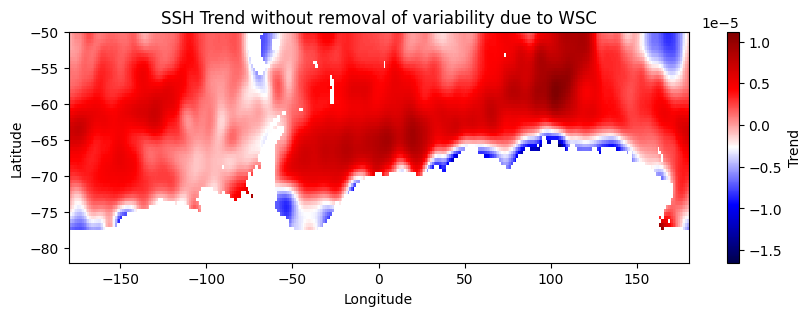

In [63]:
# SSH trends without removing ocean variability due to wind stress curl
plt.figure(figsize=(10,3))
n,slope,intercept,p_val,r_square,rmse = linregress_3D(dot_final)
plt.pcolormesh(lon, lat, slope, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SSH Trend without removal of variability due to WSC')
cbar = plt.colorbar()
cbar.set_label('Trend')

In [64]:
# MCA

In [65]:
dot_xa = xr.DataArray(dot_final, coords=[time_dot, lat, lon], dims=["time", "lon", "lat"],)
ws_curl_xa = xr.DataArray(ws_curl_final, coords=[time_dot, lat, lon], dims=["time", "lon", "lat"],)

In [66]:
print(dir(xe))


['RotatorFactory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_version', 'base_model', 'cross', 'data_container', 'linalg', 'multi', 'preprocessing', 'rotator_factory', 'single', 'utils', 'validation']


In [67]:
import inspect
#model = xe.models.MCA(n_modes=22, standardize=True)
model = xe.cross.MCA(n_modes=22, standardize=True)
#print(dir(model))
print(dot_xa.coords)
print(ws_curl_xa.coords)

#print(dir(model))
#print(dot_xa.dims)
#print(ws_curl_xa.dims)
model.fit(dot_xa, ws_curl_xa, dim='time')
comps1, comps2 = model.components()  # Singular vectors (spatial patterns)
scores1, scores2 = model.scores()  # Expansion coefficients (temporal patterns)

Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-07-01 2002-08-01 ... 2018-10-01
  * lon      (lon) float64 512B -81.75 -81.25 -80.75 ... -51.25 -50.75 -50.25
  * lat      (lat) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5


In [68]:
s1 = scores1.values; s2 = scores2.values
c1 = comps1.values; c2 = comps2.values

In [72]:
print(path)
print(gridtype)

/Users/iw2g24/PycharmProjects/SSH_project/
remapcon


In [82]:
# Full path to the 'results' directory
results_dir = os.path.join(path, 'results')

# Check if the directory already exists
if os.path.exists(results_dir):
    print("Directory already exists")
else:
    # Create the directory if it doesn't exist
    os.makedirs(results_dir, exist_ok=True)
    print("Directory created!")

Directory already exists


In [78]:
# write PCs on files
# fname = path + 'results/PCs_dot_' + gridtype + '.txt'
fname = path + 'results/PCs_dot_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s1[0,i]}\t{s1[1,i]}\t{s1[2,i]}\n')
file.close()

# fname = path + 'results/PCs_ws_curl_' + gridtype + '.txt'
fname = path + 'results/PCs_ws_curl_' + gridtype + '_seas.txt'
with open(fname, 'w') as file:
    file.write('time\tPC1\tPC2\tPC3\n')
    for i in range(len(time_dot)):
        file.write(f'{time_dot[i]}\t{s2[0,i]}\t{s2[1,i]}\t{s2[2,i]}\n')
file.close()

In [83]:
#how can you change from using cross.MCA to calling the subplots PCA1, PCA2, PCA3 etc ...

In [84]:
r_pears = []; p_pears = []
r_spear = []; p_spear = []
for m in range(1,5):
    x = scores1.sel(mode=m)
    y = scores2.sel(mode=m)
    r, p = scipy.stats.pearsonr(x, y)
    r_pears.append(np.round(r, 2)); p_pears.append(np.round(p, 2))
    r, p = scipy.stats.spearmanr(x, y)
    r_spear.append(np.round(r, 2)); p_spear.append(np.round(p, 2))

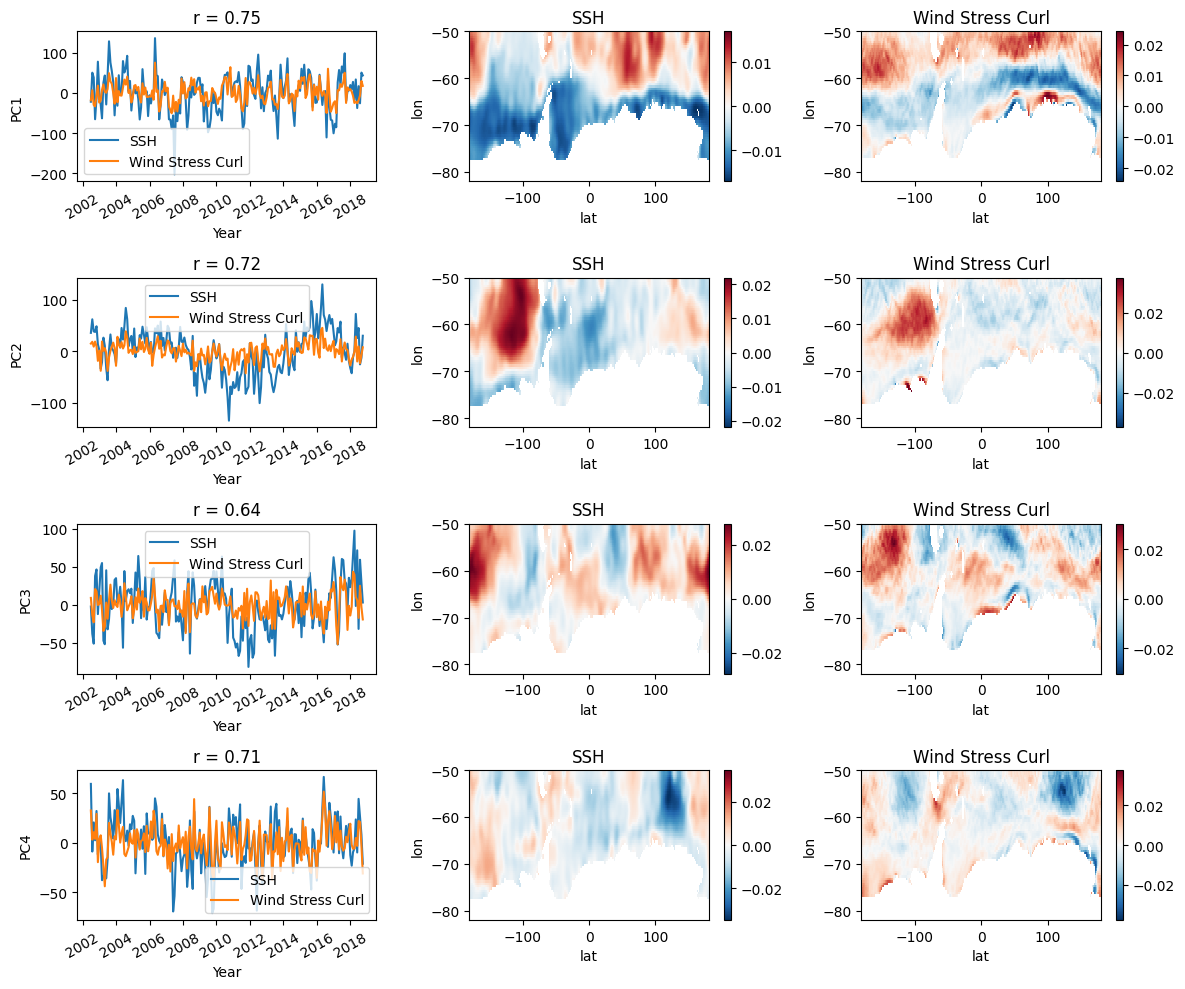

In [85]:
fig = plt.figure(figsize=(12,10))

for i in range(0,4):
    j = 3*i+1 # a = 2*(i+1) + i - 1
    
    plt.subplot(4,3,j)
    scores1.sel(mode=i+1).plot(label = 'SSH')
    scores2.sel(mode=i+1).plot(label = 'Wind Stress Curl')
    plt.title('r = ' +str(r_spear[i]))
    plt.xlabel('Year'); plt.ylabel('PC'+str(int(i+1)))
    plt.xticks(rotation=30) 
    plt.legend()
    
    plt.subplot(4,3,j+1)
    comps1.sel(mode=i+1).plot()
    plt.title('SSH')
    
    plt.subplot(4,3,j+2)
    comps2.sel(mode=i+1).plot()
    plt.title('Wind Stress Curl')

fig.tight_layout()

fig.savefig(path + 'results/MCA_output_' + gridtype + '_seas.png')

In [92]:
# compute squared covariance fraction (equivalent to explained variance in PCA)
sq_cov_frac = model.squared_covariance_fraction()
scf = sq_cov_frac.values
cum_sum = np.cumsum(scf)
print('Cumulative sum of squares:', cum_sum)
print('Squared covariance fraction:',scf)

Cumulative sum of squares: [0.47465892 0.6651117  0.73786785 0.79410528 0.83887628 0.87157563
 0.89438067 0.91278132 0.92613005 0.93846841 0.9474718  0.95434967
 0.95938988 0.96388447 0.96816961 0.97155936 0.97442698 0.9769034
 0.97924922 0.98126971 0.98309521 0.98467021]
Squared covariance fraction: [0.47465892 0.19045277 0.07275615 0.05623743 0.044771   0.03269935
 0.02280504 0.01840065 0.01334873 0.01233837 0.00900339 0.00687787
 0.0050402  0.00449459 0.00428514 0.00338976 0.00286762 0.00247642
 0.00234581 0.00202049 0.0018255  0.001575  ]


In [109]:
print(type(cum_sum))
print(len(cum_sum))
mode_percent = []
for i in range(len(cum_sum)):
    if i == 0:
        each_mode_percent =float(cum_sum[i])
        mode_percent.append(each_mode_percent)
    else:
        each_mode_percent = float(cum_sum[i]-cum_sum[i-1])
        mode_percent.append(each_mode_percent)
print('PCA fraction', mode_percent)


<class 'numpy.ndarray'>
22
PCA fraction [0.47465892440759505, 0.1904527731300748, 0.07275614859626023, 0.05623742950447985, 0.04477100120201605, 0.03269935375650357, 0.022805039845022357, 0.018400647176674112, 0.01334872762071948, 0.012338365243155902, 0.009003394000938636, 0.006877868583273328, 0.005040203668362442, 0.004494590348550931, 0.004285140154949518, 0.0033897567396756756, 0.0028676203309844217, 0.00247641870807358, 0.0023458143891621486, 0.002020489043027318, 0.0018255030265655892, 0.001575003889417781]
